# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string

# import GloVe - for word embedding
from torchtext.vocab import GloVe
global_vectors = GloVe(name='840B', dim=300)

# tokenizer
from torchtext.data import get_tokenizer

# stop word removal
nltk.download('stopwords')
from nltk.corpus import stopwords

# lemmazation
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# models
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

# tf-idf and svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nunomachado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nunomachado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [50]:
set(stopwords.words('english'))

exceptions = []

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

# Data pre-pocessing

Reading data from txt

In [2]:
df = pd.read_csv('train.txt', delimiter='\t', header=None, names=["Label", "Review"])
df_test = pd.read_csv('test_just_reviews.txt', delimiter='\t', header=None, names=["Review"])

#separating the labels into real/fake and positive/negative
df['Realness'] = df['Label'].str[:-8]
df['Sentiment'] = df['Label'].str[-8:]
df = df.drop('Label', axis=1)

# remove capitalized letters
#df['Review'] = df['Review'].str.lower()
#df['Review'] = tokenizer(df['Review'])
data = df.to_numpy()
Xt = df_test.to_numpy()[:,0]

X = data[:,0]
yr = data[:,1]
ys = data[:,2]
print(df)

                                                 Review   Realness Sentiment
0     The sheraton was a wonderful hotel! When me an...   TRUTHFUL  POSITIVE
1     We stayed at the Omni between Christmas and Ne...   TRUTHFUL  POSITIVE
2     I was REALLY looking forward to a nice relaxin...  DECEPTIVE  NEGATIVE
3     First let me say, I try not to be too critical...   TRUTHFUL  NEGATIVE
4     The Ambassador East Hotel is a terrible place ...  DECEPTIVE  NEGATIVE
...                                                 ...        ...       ...
1395  I stayed here for 5 nights last summer. I book...   TRUTHFUL  NEGATIVE
1396  Stayed here for 3 nights for a Bridgestone/Fir...   TRUTHFUL  POSITIVE
1397  I am staying here now and actually am compelle...   TRUTHFUL  NEGATIVE
1398  We stayed at this hotel with our two teenage d...   TRUTHFUL  NEGATIVE
1399  The rooms were beautiful! The staff was friend...  DECEPTIVE  POSITIVE

[1400 rows x 3 columns]


### pre processign functions

for stats

In [3]:
# takes array of reviews and prints statistics about both it
def reviews_stats(X, stop_word_rm = False, punctuation_rm = False):
    tam = []

    #tokenizing
    tokenizer = get_tokenizer("basic_english") 
    X = [tokenizer(x) for x in X]

    # stop words
    stop_words = set(stopwords.words('english'))

    if stop_word_rm == True:

        X_stop = []
        for x in X:
            X_stop.append([i for i in x if i not in stop_words])

        X = X_stop

    if punctuation_rm == True:

        X_stop = []
        for x in X:
            X_stop.append([i for i in x if i not in string.punctuation])
            
        X = X_stop

    #getting max numer of tokens in one review
    tam = []
    for x in X:
        tam.append(len(x))

    tam = np.array(tam)
    

    print(f"----- stats -----")

    print(f"tam_min-->{np.min(tam)}")
    print(f"tam_MAX-->{np.max(tam)}")
    print(f"tam_avg-->{np.average(tam)}")
    print(f"tam_median-->{np.median(tam)}")

    # distribuição do numero de palavras por review
    plt.hist(tam)
    plt.show()

    return tam, np.max(tam)

for the actual preprocessing

In [4]:
# Function that pre processes array of reviews
# if boolean=False it's a simple pre-processing (tokenization, padding and embedding)
# if false, lemmazation and stop word and pucntuation removal are also performed
def pp_x(X, stop_word_rm_lemma = True, max_words = 380, emb = True):

    #tokenizing
    tokenizer = get_tokenizer("basic_english") 
    X = [tokenizer(x) for x in X]

    #print(f"after tokenization: X[0]-->{X[0]}")

    if stop_word_rm_lemma == True:

        # lemmazation
        wnl = WordNetLemmatizer()

        # stop word removal (and punctuation)
        stop_words = set(stopwords.words('english'))

        # apply both stop word removal and lemmazation
        X_stop = []
        for x in X:
            X_stop.append([wnl.lemmatize(i) for i in x if i not in stop_words and i not in string.punctuation])

        X = X_stop

    #print(f"after stop word and lemma: X_stop[0]-->{X_stop[0]}")
    print(f"max_words-->{max_words}")
    #print(f"type(X_stop[0])-->{type(X_stop[0])}")

    #padding
    X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]

    #print(f"after padding: X_stop[0]-->{X_stop[0]}")

    if emb == True:
        #embeddings
        X_emb = []
        for token in X:
            # tokenize and use glove word embedding
            X_emb.append(np.array(global_vectors.get_vecs_by_tokens(token)))

        X = np.array(X_emb)

        #print(f"after embedding: X_emb[0]-->{X_emb[0]}")
        print(f"X_emb.shape-->{X.shape}")

    return X

----- stats -----
tam_min-->28
tam_MAX-->864
tam_avg-->168.855
tam_median-->145.0


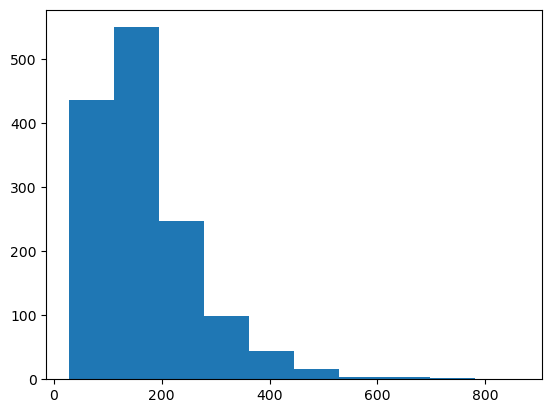

----- stats -----
tam_min-->39
tam_MAX-->868
tam_avg-->169.495
tam_median-->148.5


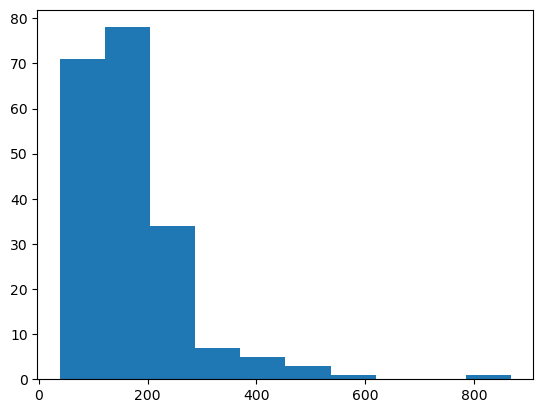

--
----- stats -----
tam_min-->13
tam_MAX-->380
tam_avg-->73.12
tam_median-->63.0


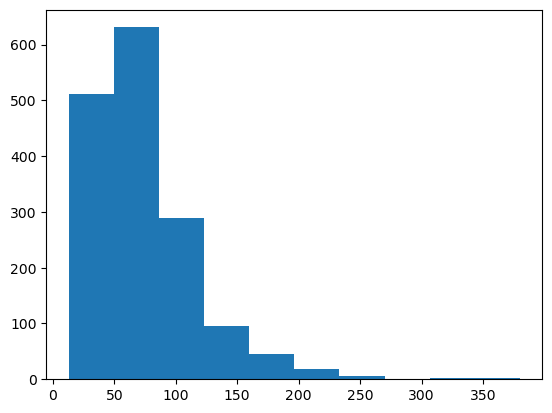

--


In [5]:
reviews_stats(X)
reviews_stats(Xt)
print("--")
X_all = np.concatenate((X,Xt), axis=0)
reviews_stats(X_all, True, True)
print("--")

In [6]:
X_pp = pp_x(X, stop_word_rm_lemma = True, max_words = 380)
Xt_pp = pp_x(Xt, stop_word_rm_lemma = True, max_words = 380)

X_emb = pp_x(X, stop_word_rm_lemma = True, max_words = 868)
Xt_emb =  pp_x(Xt, stop_word_rm_lemma = True, max_words = 868)

max_words-->380
X_emb.shape-->(1400, 380, 300)
max_words-->380
X_emb.shape-->(200, 380, 300)
max_words-->868
X_emb.shape-->(1400, 868, 300)
max_words-->868
X_emb.shape-->(200, 868, 300)


labels preprocessing

In [7]:
# simple conversion to 0'a and 1's for the
# deceptivness (1=truthful) and sentiment (1=positive)
for i in range(len(ys)):
    if ys[i] == "POSITIVE":
        ys[i] = 1
    else:
        ys[i] = 0

    if yr[i] == "TRUTHFUL":
        yr[i] = 1
    else:
        yr[i] = 0

ys = np.array(ys)
yr = np.array(yr)

testing dimensions

In [8]:
print(f"type(X_emb)-->{type(X_emb)}")
print(f"type(Xt_emb)-->{type(Xt_emb)}")
print(f"type(ys)-->{type(ys)}")
print(f"type(yr)-->{type(yr)}\n")

print(f"X_emb.shape-->{X_emb.shape}")
print(f"Xt_emb.shape-->{Xt_emb.shape}")
print(f"ys.shape-->{ys.shape}")
print(f"yr.shape-->{yr.shape}")

type(X_emb)--><class 'numpy.ndarray'>
type(Xt_emb)--><class 'numpy.ndarray'>
type(ys)--><class 'numpy.ndarray'>
type(yr)--><class 'numpy.ndarray'>

X_emb.shape-->(1400, 868, 300)
Xt_emb.shape-->(200, 868, 300)
ys.shape-->(1400,)
yr.shape-->(1400,)


In [9]:
# delete cache
del(global_vectors)
#save processed numpy arrays
np.save("./processed_train/X_emb.npy", X_emb)
np.save("./processed_train/Xt_emb.npy", Xt_emb)
np.save("./processed_train/ys.npy", ys)
np.save("./processed_train/yr.npy", yr)

## more pre processed, lemmazation and stop word removal
np.save("./processed_train/X_pp.npy", X_pp)
np.save("./processed_train/Xt_pp.npy", Xt_pp)

# Models

## Load training data

In [10]:
X_emb = np.load("processed_train/X_pp.npy", allow_pickle=True)
Xt_emb = np.load("processed_train/Xt_pp.npy", allow_pickle=True)
yr = np.load("processed_train/yr.npy", allow_pickle=True)
ys =np.load("processed_train/ys.npy", allow_pickle=True)
yr = yr.astype('float64') 
ys = ys.astype('float64') 

y = np.concatenate((np.transpose([yr]), np.transpose([ys])), axis=1)

print(f"type(X_emb)-->{type(X_emb)}")
print(f"type(Xt_emb)-->{type(Xt_emb)}")
print(f"type(ys)-->{type(ys)}")
print(f"type(yr)-->{type(yr)}\n")

print(f"y.shape-->{y.shape}")
print(f"type(y)-->{type(y)}\n")

print(f"X_emb.shape-->{X_emb.shape}")
print(f"Xt_emb.shape-->{Xt_emb.shape}")
print(f"ys.shape-->{ys.shape}")
print(f"yr.shape-->{yr.shape}")

type(X_emb)--><class 'numpy.ndarray'>
type(Xt_emb)--><class 'numpy.ndarray'>
type(ys)--><class 'numpy.ndarray'>
type(yr)--><class 'numpy.ndarray'>

y.shape-->(1400, 2)
type(y)--><class 'numpy.ndarray'>

X_emb.shape-->(1400, 380, 300)
Xt_emb.shape-->(200, 380, 300)
ys.shape-->(1400,)
yr.shape-->(1400,)


## LSTM

In [11]:
# https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Bidirectional
from keras.optimizers import Adam

X_train, X_val, y_train, y_val = train_test_split(X_emb, ys, test_size=0.1, shuffle= True, random_state=42)

# model initialization
model = Sequential()
model.add(Bidirectional(LSTM(64), input_shape = (X_emb.shape[1], X_emb.shape[2])))
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy',
              #optimizer='adam',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy'])
# model summary
#model.build(input_shape = (64, X_emb.shape[1], X_emb.shape[2]))
model.summary()

2023-10-26 21:42:13.855506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 21:42:21.056444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 190,001
Trainable params: 190,001
Non-trainable params: 0
_________________________________________________________________


In [12]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', mode='min', verbose=5, patience=8, restore_best_weights=True)

cb_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.9,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=0,
    min_lr=1e-4,
)

bf = model.fit(x=X_train, y=y_train, validation_data = (X_val, y_val), epochs=50, batch_size=32, callbacks=[es, cb_plateau] )

Epoch 1/50
40/40 [==============================] - 33s 687ms/step - loss: 0.6082 - accuracy: 0.6865 - val_loss: 0.3828 - val_accuracy: 0.8786 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 17s 429ms/step - loss: 0.3083 - accuracy: 0.8865 - val_loss: 0.3055 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 15s 369ms/step - loss: 0.2162 - accuracy: 0.9302 - val_loss: 0.3467 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9444
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
40/40 [==============================] - 15s 377ms/step - loss: 0.1577 - accuracy: 0.9444 - val_loss: 0.3059 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 15s 374ms/step - loss: 0.1090 - accuracy: 0.9651 - val_loss: 0.4298 - val_accuracy: 0.8786 - lr: 9.0000e-04
Epoch 6/50
40/40 [==============================] - ETA: 

### Metrics

In [13]:
# best epoch obtained
results_test = model.evaluate(X_val, y_val)
print(results_test)

5/5 [==============================] - 1s 114ms/step - loss: 0.2254 - accuracy: 0.9357
[0.22542014718055725, 0.9357143044471741]


In [14]:
# summary of the model applied to the validation set
y_preds = model.predict(X_val)
for i in range(len(y_preds)):
    for j in range(len(y_preds[i])):
        if y_preds[i,j] > 0.5:
            y_preds[i,j] = 1
        else:
            y_preds[i,j] = 0

print(metrics.classification_report(y_val, y_preds, target_names=['real', 'sentiment']))
print(metrics.multilabel_confusion_matrix(y_val, y_preds))

# saving sentiment predictions
np.save('sentiment_pred.npy', y_preds[:, -1])

5/5 [==============================] - 1s 111ms/step
              precision    recall  f1-score   support

        real       0.96      0.92      0.94        74
   sentiment       0.91      0.95      0.93        66

    accuracy                           0.94       140
   macro avg       0.94      0.94      0.94       140
weighted avg       0.94      0.94      0.94       140

[[[63  3]
  [ 6 68]]

 [[68  6]
  [ 3 63]]]


In [15]:
y_preds[:, -1]

array([1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 1.], dtype=float32)

Checking data

<function matplotlib.pyplot.show(close=None, block=None)>

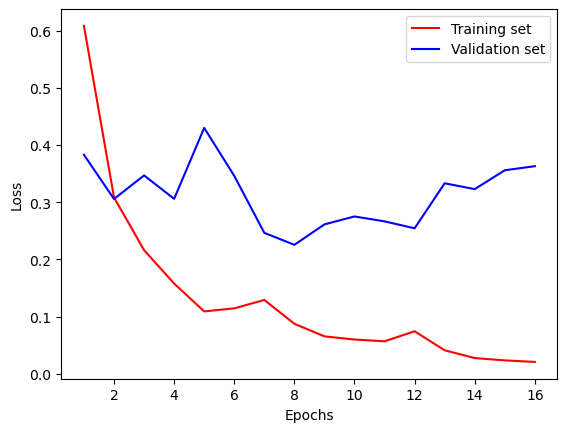

In [16]:
loss = bf.history['loss']
val_loss = bf.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label = 'Training set')
plt.plot(epochs, val_loss, 'b', label = 'Validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

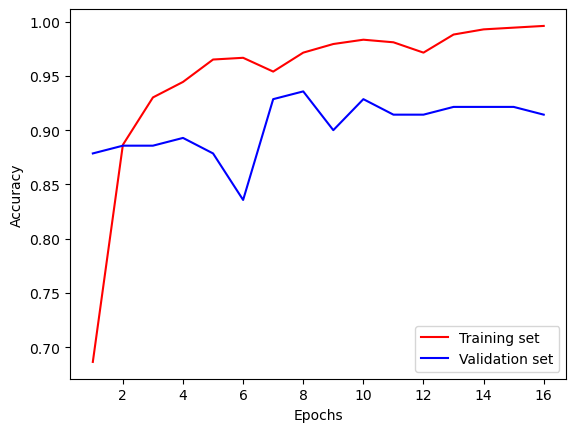

In [17]:
loss = bf.history['accuracy']
val_loss = bf.history['val_accuracy']
epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'r', label = 'Training set')
plt.plot(epochs, val_loss, 'b', label = 'Validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show

## SVM with TF-IDF

In [18]:
X_pp_idf = pp_x(X, emb = False)
Xt_pp_idf = pp_x(Xt, emb = False)

max_words-->380
max_words-->380


In [19]:
tfidf = TfidfVectorizer(lowercase=False)

In [20]:
separator = ' '

X_pp_joined = np.empty(1400, dtype=object)
for i in range(len(X_pp_idf)):
  X_pp_joined[i] = separator.join(X_pp_idf[i])

In [21]:
j=50
print(X_pp_idf[j])
print(X_pp_joined[j])

['recently', 'stayed', 'james', 'chicago', 'returning', 'anytime', 'soon', 'staff', 'unfriendly', 'say', 'least', 'price', 'outrageous', 'also', 'fan', 'fact', 'allow', 'pet', 'guest', 'enough', 'space', 'gym', 'lack', 'variety', 'equipment', 'limit', 'option', 'severely', 'ultimately', 'unimpressed', 'service', 'whole', 'would', 'recommend', 'avoid', 'establishment', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

In [22]:
tfidf_result = tfidf.fit_transform(X_pp_joined)
print(tfidf_result.shape)

(1400, 8032)


In [23]:
from sklearn.model_selection import cross_val_score

#classifier = MultiOutputClassifier(SVC(kernel='linear'))
classifier = SVC(kernel='rbf')
# Create an SVM classifier
#classifier = (SVC(kernel='linear'))

from sklearn.model_selection import RepeatedStratifiedKFold

#cross_val = RepeatedStratifiedKFold(n_splits=20, n_repeats=10)
#scores = cross_val_score(classifier, tfidf_result, yr, cv=cross_val)

In [24]:
#print(scores.shape)
#print(np.average(scores), np.std(scores))

RepeatedStratifiedKFold(n_splits=20, n_repeats=10) \\
rbf 0.8762857142857143 0.03643389316870448 \\
linear 0.8766428571428573 0.03452823452758389 \\
sigmoid 0.8762857142857143 0.037646042153139


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(tfidf_result, y, test_size=0.1, shuffle= True, random_state=42)
print(X_train.shape)

(1260, 8032)


In [43]:
# Train the classifier
classifier.fit(X_train, y_train[:,0])

# Predict on the test set
y_pred = classifier.predict(X_val)

# Evaluate the classifiers
from sklearn.metrics import accuracy_score, confusion_matrix, multilabel_confusion_matrix, classification_report, average_precision_score

accuracy_s = accuracy_score(y_val[:,0], y_pred)

#print(multilabel_confusion_matrix(y_val, y_pred))
print(confusion_matrix(y_val[:,0], y_pred))
print(classification_report(y_val[:,0], y_pred))
print("Accuracy score:",  accuracy_s)

[[55  4]
 [12 69]]
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87        59
         1.0       0.95      0.85      0.90        81

    accuracy                           0.89       140
   macro avg       0.88      0.89      0.88       140
weighted avg       0.89      0.89      0.89       140

Accuracy score: 0.8857142857142857


In [44]:

'''
for i in range(len(y_pred)):
    if y_pred[i] == "TRUTHFUL":
        y_pred[i] = 1
    else:
        y_pred[i] = 0

for i in range(len(y_val)):
    if y_val[i][1] == "POSITIVE":
        y_val[i][1] = 1
    else:
        y_val[i][1] = 0

    if y_val[i][0] == "TRUTHFUL":
        y_val[i][0] = 1
    else:
        y_val[i][0] = 0
'''

'\nfor i in range(len(y_pred)):\n    if y_pred[i] == "TRUTHFUL":\n        y_pred[i] = 1\n    else:\n        y_pred[i] = 0\n\nfor i in range(len(y_val)):\n    if y_val[i][1] == "POSITIVE":\n        y_val[i][1] = 1\n    else:\n        y_val[i][1] = 0\n\n    if y_val[i][0] == "TRUTHFUL":\n        y_val[i][0] = 1\n    else:\n        y_val[i][0] = 0\n'

In [45]:
sentiment_pred = np.load('sentiment_pred.npy')
print(y_pred.shape, sentiment_pred.shape)

for i in range(len(sentiment_pred)):
    if sentiment_pred[i] == 1.0:
        sentiment_pred[i] = 1
    else:
        sentiment_pred[i] = 0
print(sentiment_pred)
y_all_predictions = np.concatenate((y_pred.reshape(140, 1), sentiment_pred.reshape(140, 1)), axis=1)
y_all_predictions = y_all_predictions.astype('int')
y_val = y_val.astype('int')

print(y_all_predictions.dtype)


# Evaluate the classifiers
from sklearn.metrics import accuracy_score, confusion_matrix, multilabel_confusion_matrix, classification_report, average_precision_score

#print(y_val, y_all_predictions)
accuracy_s = accuracy_score(y_val, y_all_predictions)

print(multilabel_confusion_matrix(y_val, y_all_predictions))
#print(confusion_matrix(y_val, y_all_predictions))
print(classification_report(y_val, y_all_predictions))
print('Accuracy', accuracy_s)


(140,) (140,)
[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.]
int64
[[[55  4]
  [12 69]]

 [[68  6]
  [ 3 63]]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        81
           1       0.91      0.95      0.93        66

   micro avg       0.93      0.90      0.91       147
   macro avg       0.93      0.90      0.91       147
weighted avg       0.93      0.90      0.91       147
 samples avg       0.71      0.71      0.70       147

Accuracy 0.8285714285714286


/Users/nunomachado/opt/anaconda3/envs/LN23/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunomachado/opt/anaconda3/envs/LN23/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
print(f"y_all_predictions-->{y_all_predictions}")
print(f"y_all_predictions.shape-->{y_all_predictions.shape}")

y_all_predictions-->[[0 1]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [1 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [1 1]
 [1 0]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [1 0]
 [0 1]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [1 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 0]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 0]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 1]]

In [47]:
print(f"y_val-->{y_val}")
print(f"y_val.shape-->{y_val}")

y_val-->[[0 1]
 [1 1]
 [1 0]
 [0 1]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [0 1]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [1 0]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 1]
 [1 0]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [1 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 1]
 [1 0]
 [0 1]
 [1 1]
 [1 0]
 [1 1]
 [1 0]
 [0 0]
 [0 1]
 [1 0]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 0]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [1 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 0]
 [1 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
y_val.shape

In [48]:
for i in range(len(y_all_predictions)):
    if y_all_predictions[i][1] == 1.0:
        y_all_predictions[i][1] = 1
    else:
        y_all_predictions[i][1] = 0

#print(y_all_predictions)